In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time

data = pd.read_csv('META.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
...,...,...,...,...,...,...,...
2946,2024-02-05,469.880005,471.899994,459.220001,459.410004,459.410004,40832400
2947,2024-02-06,464.000000,467.119995,453.000000,454.720001,454.720001,21655200
2948,2024-02-07,458.000000,471.519989,456.179993,469.589996,469.589996,23066000
2949,2024-02-08,468.320007,470.589996,465.029999,470.000000,470.000000,18815100


In [260]:
# Device agnostiv code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [261]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date']

0      2012-05-18
1      2012-05-21
2      2012-05-22
3      2012-05-23
4      2012-05-24
          ...    
2946   2024-02-05
2947   2024-02-06
2948   2024-02-07
2949   2024-02-08
2950   2024-02-09
Name: Date, Length: 2951, dtype: datetime64[ns]

In [262]:
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])

C:\Users\Kumud Jain\AppData\Local\Temp\ipykernel_7592\2538951630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


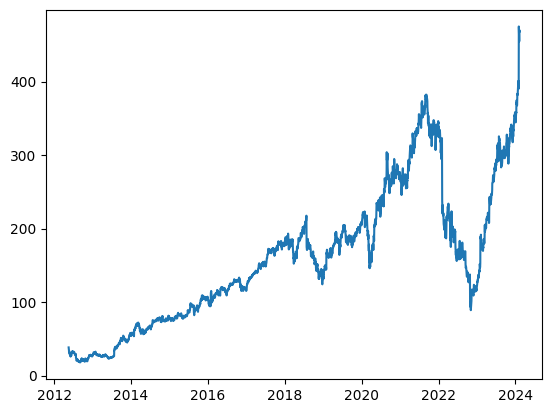

In [263]:
plt.plot(data['Date'], data['Close'])

In [264]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2012-05-30,28.190001,28.840000,31.910000,33.029999,32.000000,31.000000,34.029999,38.230000
2012-05-31,29.600000,28.190001,28.840000,31.910000,33.029999,32.000000,31.000000,34.029999
2012-06-01,27.719999,29.600000,28.190001,28.840000,31.910000,33.029999,32.000000,31.000000
2012-06-04,26.900000,27.719999,29.600000,28.190001,28.840000,31.910000,33.029999,32.000000
2012-06-05,25.870001,26.900000,27.719999,29.600000,28.190001,28.840000,31.910000,33.029999
...,...,...,...,...,...,...,...,...
2024-02-05,459.410004,474.989990,394.779999,390.140015,400.059998,401.019989,394.140015,393.179993
2024-02-06,454.720001,459.410004,474.989990,394.779999,390.140015,400.059998,401.019989,394.140015
2024-02-07,469.589996,454.720001,459.410004,474.989990,394.779999,390.140015,400.059998,401.019989


# Changing data Size here !!

In [265]:
# For 6 Months == 180 Day 
# shifted_df = dc(shifted_df[:180])

# For 1 Year == 365 Day 
#shifted_df = dc(shifted_df[:365])

# For 2 Months == 730 Day 
#shifted_df = dc(shifted_df[:730])

# For 5 Year == 1825 Day 
#shifted_df = dc(shifted_df[:1825])

# For 7 Year == 2555 Day 
#shifted_df = dc(shifted_df[:2555])

In [266]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [267]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [268]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()
    return running_loss

In [269]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()
    return avg_loss_across_batches

In [270]:
start_time = time.time()
# Preparing Data

# Convert to numpy
shifted_df_as_np = shifted_df.to_numpy()
# Performing Scaling as stock prices vary very much 
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
X = dc(np.flip(X, axis=1))

split_index = int(len(X) * 0.90)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

# LSTM require extra dimension
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Convert data to tensor
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

# Declaring Loaders
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Declaring Batch Size
batch_size = 16

# Lading Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    break

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")


Execution time: 0.020172119140625 seconds


In [271]:
# Tunning Hyper Parameters
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [272]:
start_time = time.time()
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Epoch: 1


Batch 100, Loss: 0.175

Val Loss: 0.088
***************************************************

Epoch: 2
Batch 100, Loss: 0.013

Val Loss: 0.026
***************************************************

Epoch: 3
Batch 100, Loss: 0.004

Val Loss: 0.022
***************************************************

Epoch: 4
Batch 100, Loss: 0.003

Val Loss: 0.019
***************************************************

Epoch: 5
Batch 100, Loss: 0.002

Val Loss: 0.016
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.014
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.012
***************************************************

Epoch: 8
Batch 100, Loss: 0.001

Val Loss: 0.010
***************************************************

Epoch: 9
Batch 100, Loss: 0.001

Val Loss: 0.009
***************************************************

Epoch: 10
Batch 100, Loss: 0.001

Val Loss: 0.008
*****************************************